In [2]:
import matplotlib.pyplot as plt
from segmentation import predict
import cv2

from utils.cluster_points import hcluster, mean_cluster
from utils.geometry import angle_between, angle_diff

import numpy as np

from utils.image_manipulation import *

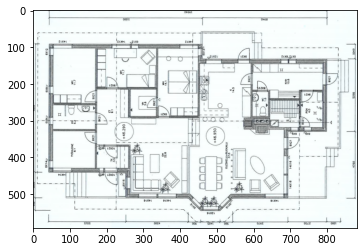

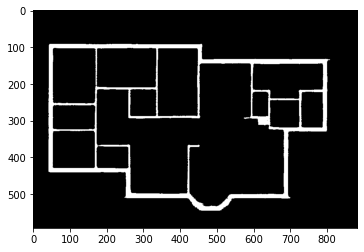

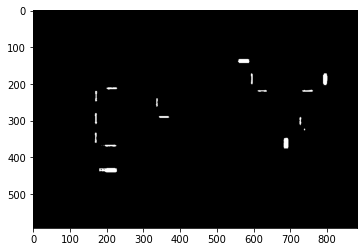

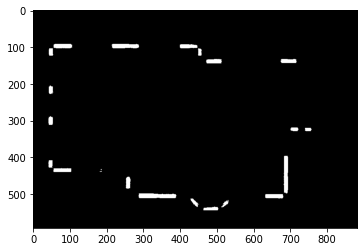

In [3]:
original = cv2.imread('./original.png')
rooms_pred, icons_pred, heatmaps = predict(original)

plt.imshow(original)
plt.show()

# Structural elements
walls_closed = as_image(rooms_pred == 2)
plt.imshow(walls_closed, cmap='gray')
plt.show()

doors_pixels = as_image(icons_pred ==  2)
plt.imshow(doors_pixels, cmap='gray')
plt.show()

windows_pixels = as_image(icons_pred ==  1)
plt.imshow(windows_pixels, cmap='gray')
plt.show()
# Decorative elements
closets_pixels = as_image(icons_pred == 3)
toilets_pixels = as_image(icons_pred == 5)
sinks_pixels = as_image(icons_pred == 6)
bathtubs_pixels = as_image(icons_pred == 9)
##

In [37]:
def wall_to_poly(wall, width):
    """Generates the vertices to a given wall with two endpoints and a width."""
    v = wall[1] - wall[0]
    p = np.array([v[1], -v[0]])
    p = p / np.linalg.norm(p)

    p1 = wall[0] + p*(width/2)
    p2 = p1 + v
    p3 = p2 - p*width
    p4 = p3 - v

    return np.array([p1, p2, p3, p4])

def warp_fitness(wall, wall_pixels, width):

    length = np.linalg.norm(wall[1] - wall[0])
    rect = wall_to_poly(wall, width)
    src = np.float32(rect[:3,:])
    dest = np.float32([[0, 0], [length, 0], [length, width]])
    M = cv2.getAffineTransform(src, dest)
    new_img = cv2.warpAffine(wall_pixels, M, (wall_pixels.shape[1], wall_pixels.shape[0]), cv2.INTER_NEAREST)
    new_img = cv2.getRectSubPix(new_img, np.intp([length, width]), (length//2, width//2))

    n_horizontal_pixels = np.sum(np.sum(new_img, axis=0) > 0)
    ratio = n_horizontal_pixels/new_img.shape[1]

    if ratio > 0.0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(wall_pixels, cmap='gray', interpolation='none')
        axes[0].plot(wall[0,0], wall[0,1], color='red', marker='o', markersize=10)
        axes[0].plot(wall[1,0], wall[1,1], color='red', marker='o', markersize=10)

        axes[1].imshow(new_img, cmap='gray', interpolation='none')

        fig.tight_layout()
        plt.show()

        print(ratio)
    return ratio

def fitness(wall, wall_pixels, width):
    new_image = np.zeros(wall_pixels.shape)
    rect = wall_to_poly(wall, width)
    new_image = np.int0(cv2.fillConvexPoly(new_image, points = np.array(rect, dtype=np.int32), color = 255))//255

    i = np.sum(new_image & wall_pixels)
    total = np.sum(new_image)
    ratio = i/total
    return ratio

def get_junctions(heatmaps, wall_pixels, junction_threshold):
    wall_heatmaps = heatmaps[:13]
    junctions = wall_heatmaps.sum(axis=0) * wall_pixels
    junctions = np.where(junctions > junction_threshold, 1, 0)

    contours, _ = cv2.findContours(junctions.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []

    for c in contours:
        # Get the contours bounding rectangle:
        boundRect = cv2.boundingRect(c)

        # Get the centroid of the rectangle:
        cX = int(boundRect[0] + 0.5 * boundRect[2])
        cY = int(boundRect[1] + 0.5 * boundRect[3])
        centroids.append((cX, cY))

    return centroids

def normalize_points(all_points, distance_threshold):
    def sort_key(c):
        return (c[0], -c[1])

    allx = [p[0] for p in all_points]
    ally = [p[1] for p in all_points]

    xclusters = hcluster(allx, distance_threshold)
    xaverages = mean_cluster(xclusters[1])

    yclusters = hcluster(ally, distance_threshold)
    yaverages = mean_cluster(yclusters[1])

    res = []
    for px, py in all_points:
        px = xaverages[1][xclusters[0][px]]
        py = yaverages[1][yclusters[0][py]]

        res.append([px, py])

    with_original = zip(all_points, res)
    with_original = sorted(with_original, key=lambda p: sort_key(p[1]))
    original, normalized = [p[0] for p in with_original], [p[1] for p in with_original]
    return np.array(original).astype(np.intp), np.array(normalized).astype(np.intp)

def try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
    angle = angle_between(c2 - c1, np.array([1, 0]))
    if any(angle_diff(a, angle) < 5 for a in angles_tried[tuple(c1)]): # do not points that go over tried junctios
        return False

    # 70 yields best results for the primary school floor plan, but it's hammered in
    if any(angle_diff(a, angle) < 70 for a in angles_put[tuple(c1)]): # do not add overlapping walls
        return False

    # We add this one immediatly because if not we could place a wall over two junction points, which
    # does not make sense
    angles_tried[tuple(c1)].add(angle)

    inter_threshold = 0.75
    # inter = loss(np.array((o1, o2)), wallPixels, 7, verbose_threshold=inter_threshold)
    inter = warp_fitness(np.array((o1, o2)), wall_pixels, 7)
    if inter > inter_threshold:
        # Do not allow a wall going back the same direction (might happen if its further on the x axis)
        angles_put[tuple(c1)].add(angle)
        angles_put[tuple(c2)].add(angle_between(c1 - c2, np.array([1, 0])))

        return True
    return False

def get_walls(heatmaps, wall_pixels, junction_threshold=0.2, distance_threshold=5):
    junctions = get_junctions(heatmaps, wall_pixels//255, junction_threshold)
    originals, points = normalize_points(junctions, distance_threshold)

    walls = []

    angles_put = {tuple(p): set() for p in points}
    angles_tried = {tuple(p): set() for p in points}

    for i in range(len(points)-1):
        c1, o1 = points[i], originals[i]

        c2, o2 = points[i+1], originals[i+1]
        angle = angle_between(c2 - c1, np.array([1, 0]))
        if abs(angle - 90) < 5: # check if vertical
            if try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
                walls.append((c1, c2))

        # find next that is horizontal
        c2 = [c2 for c2 in zip(points[i+1:], originals[i+1:]) if c1[1] == c2[0][1]]
        if c2 != []:
            c2, o2 = c2[0]
            if try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
                walls.append((c1, c2))

        for j in range(i+1, len(points)):
            c2, o2 = points[j], originals[j]
            if try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
                walls.append((c1, c2))

    return tuple(np.array(w).astype(np.float32) for w in walls)

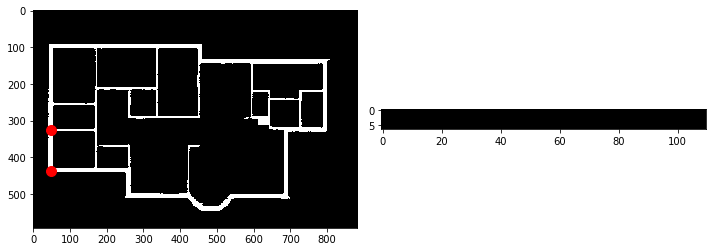

1.0


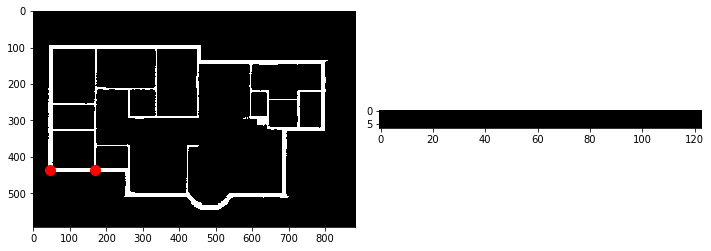

1.0


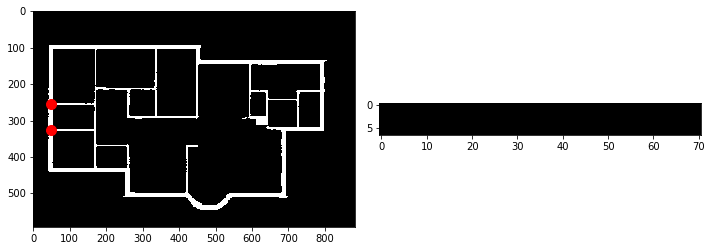

1.0


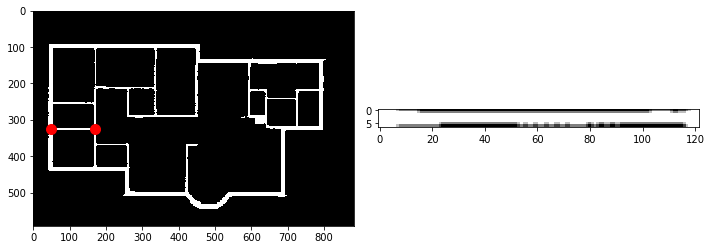

1.0


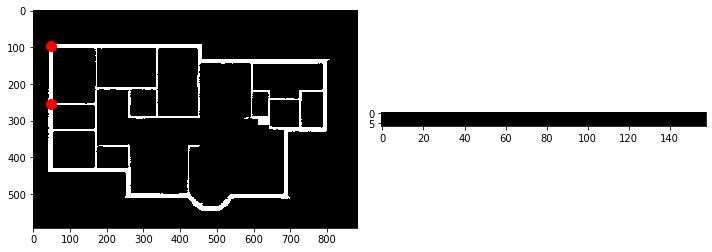

1.0


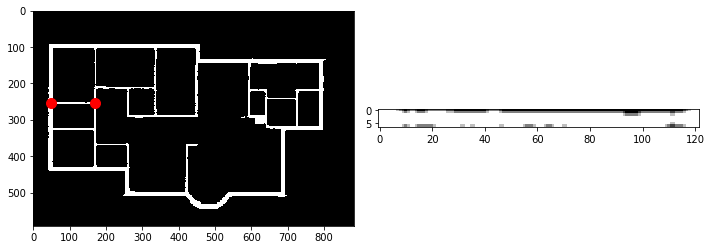

1.0


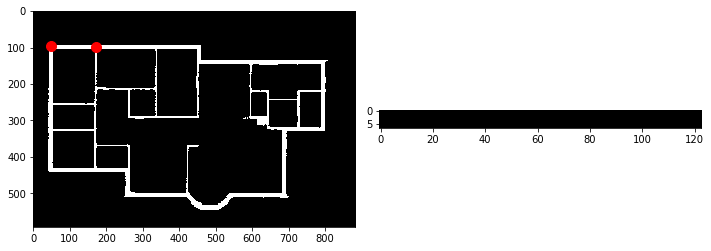

1.0


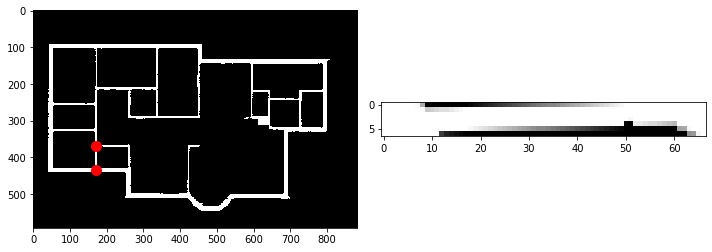

1.0


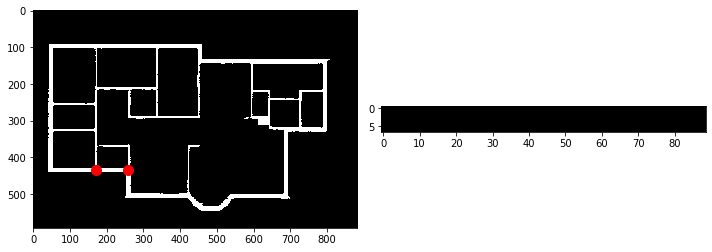

1.0


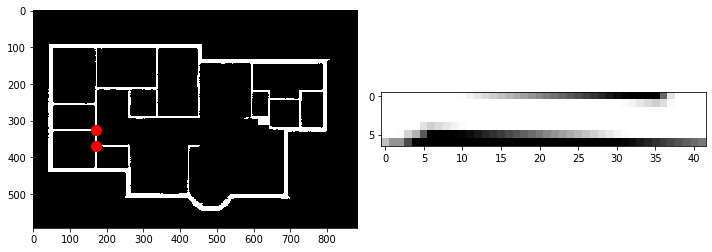

1.0


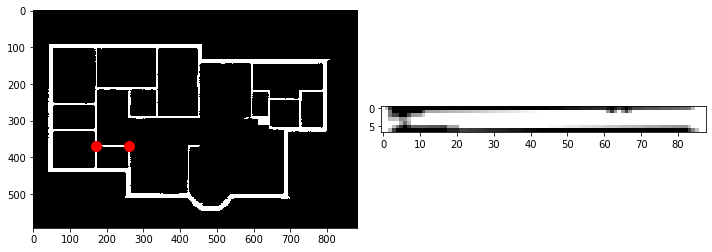

1.0


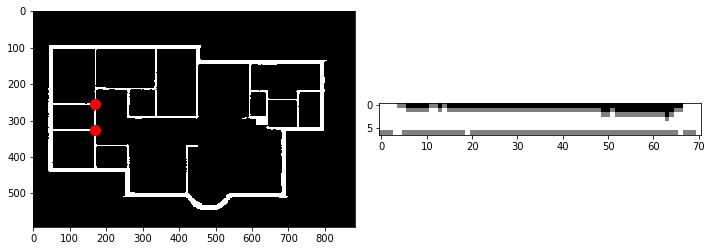

1.0


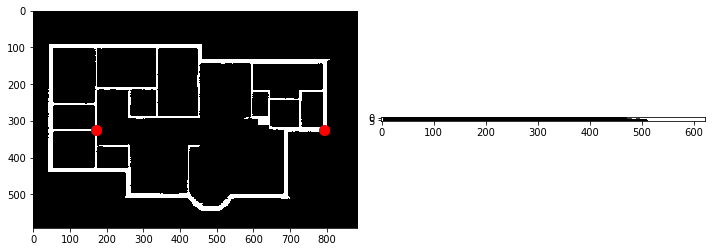

0.2520064205457464


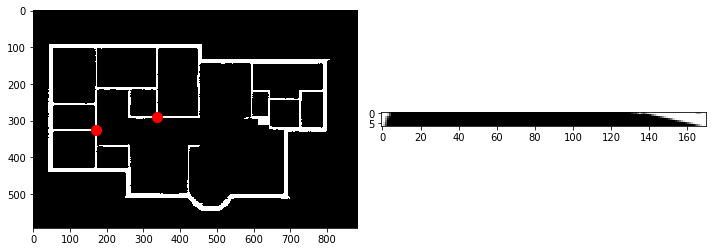

0.2647058823529412


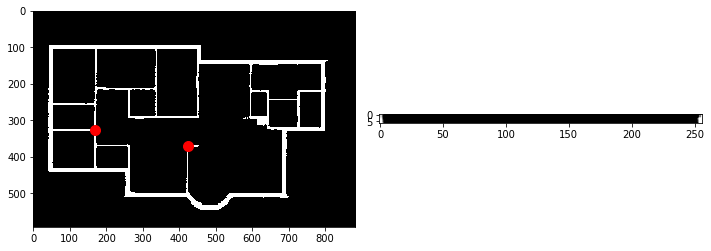

0.03125


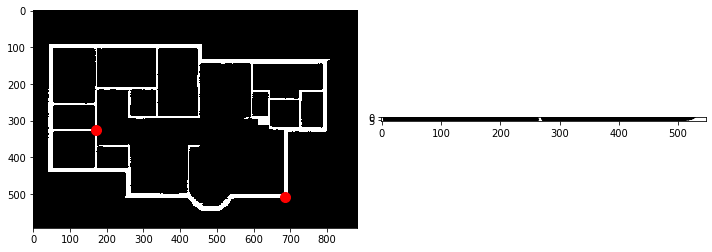

0.08409506398537477


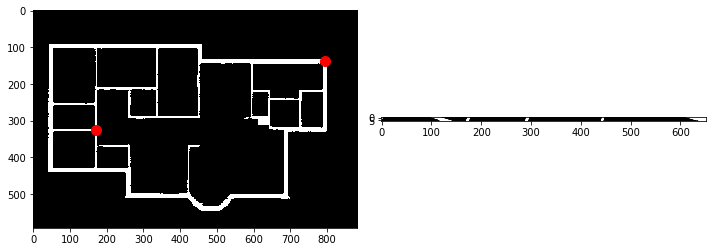

0.17972350230414746


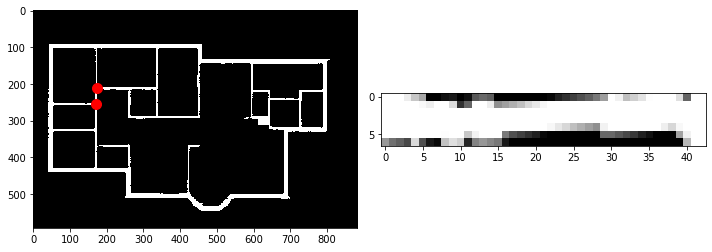

1.0


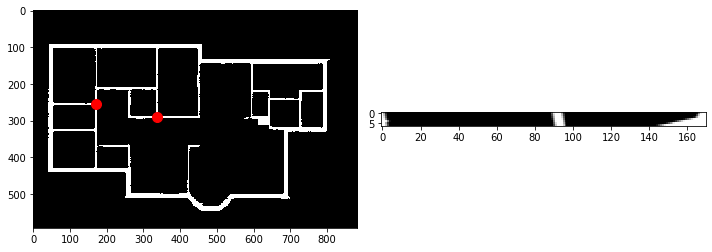

0.22941176470588234


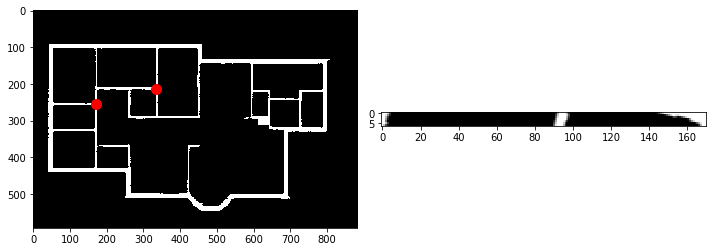

0.2411764705882353


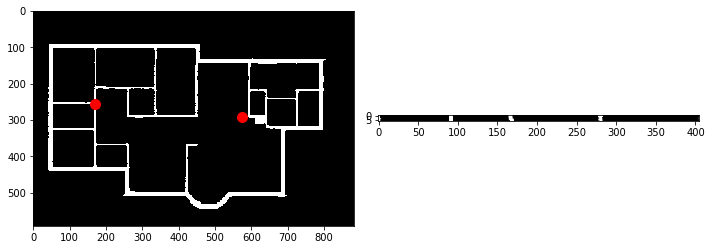

0.06666666666666667


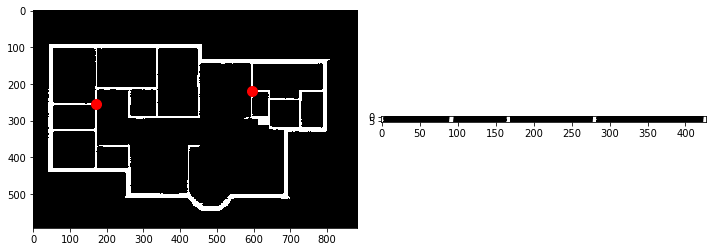

0.0702576112412178


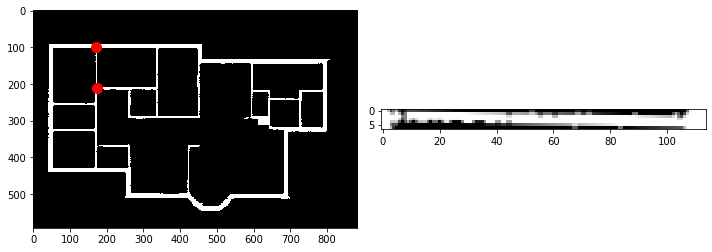

1.0


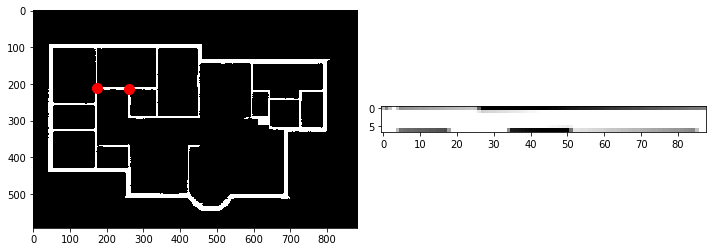

1.0


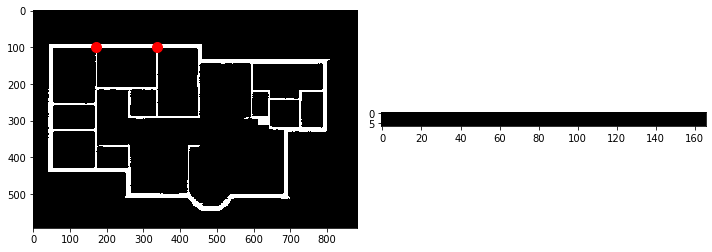

1.0


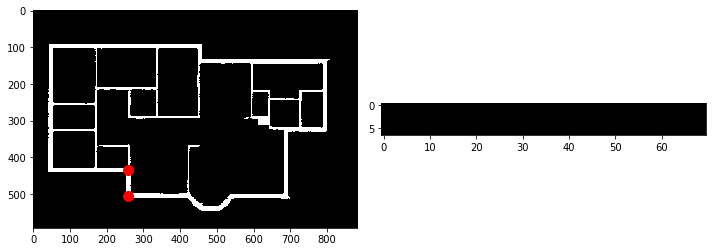

1.0


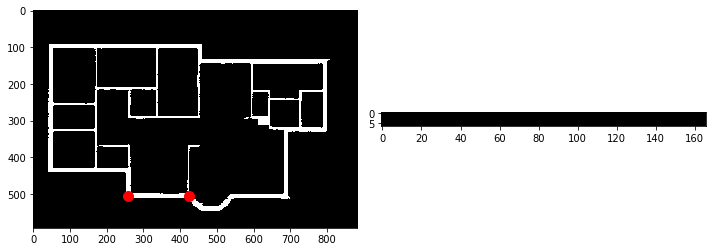

1.0


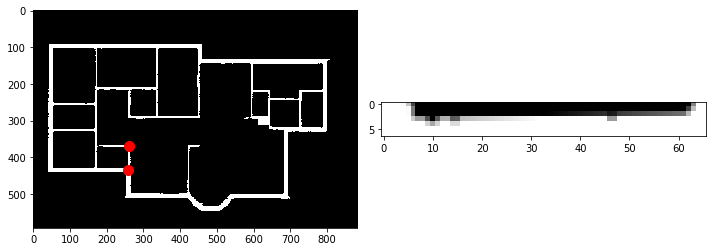

1.0


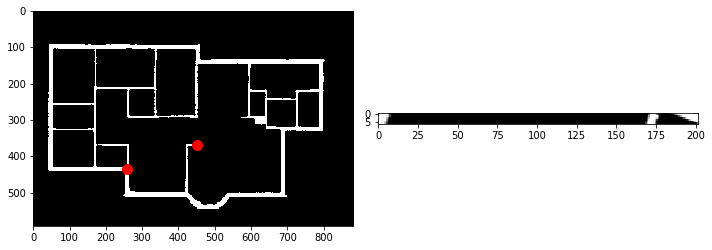

0.19801980198019803


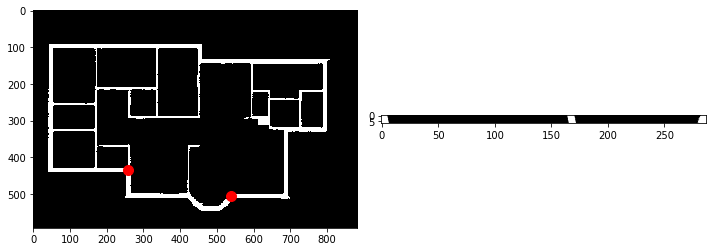

0.08013937282229965


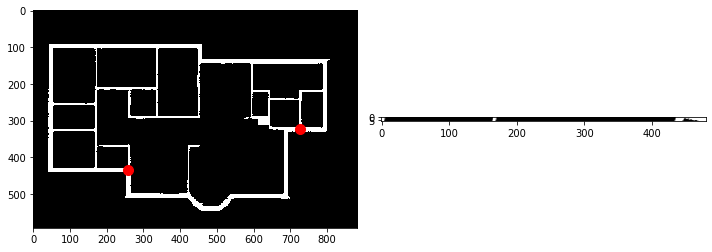

0.13333333333333333


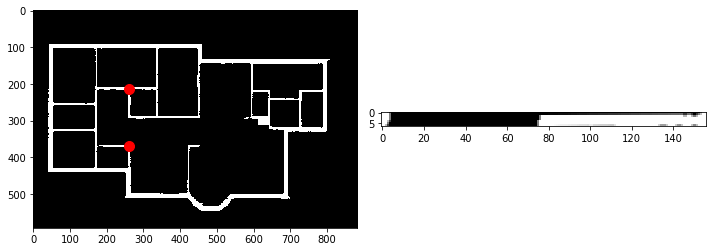

0.5512820512820513


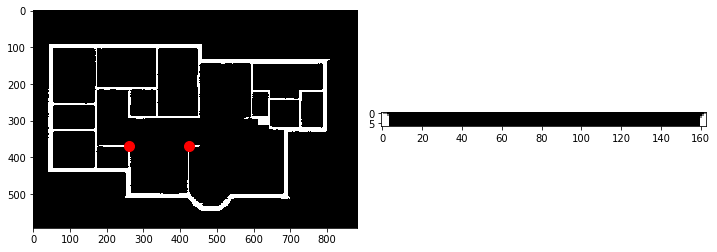

0.04294478527607362


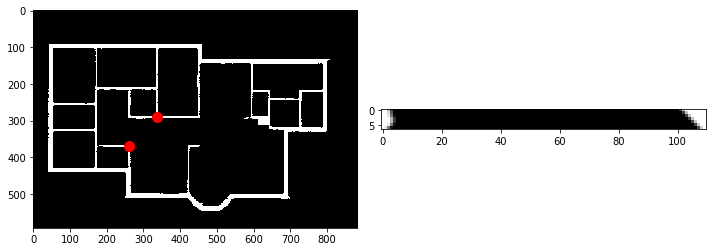

0.12727272727272726


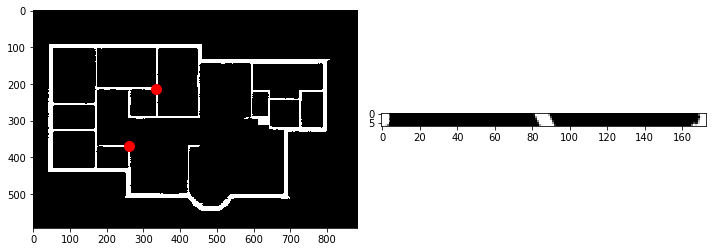

0.14450867052023122


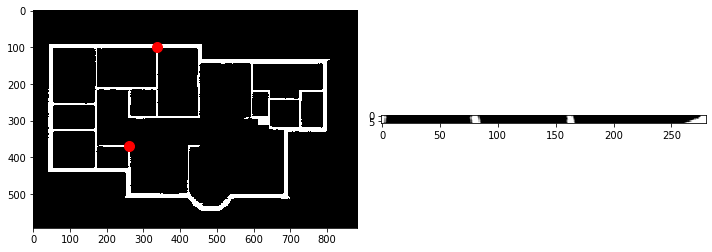

0.15357142857142858


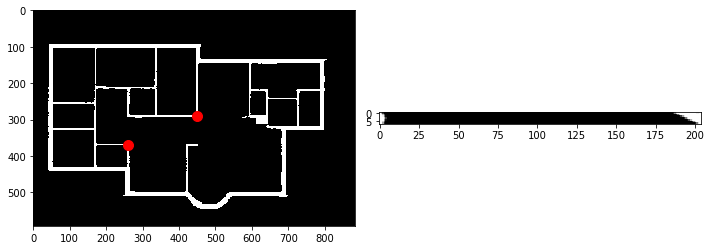

0.11274509803921569


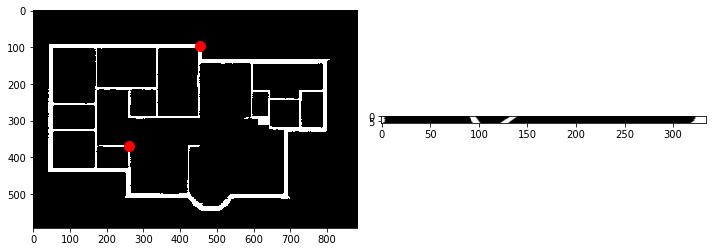

0.16167664670658682


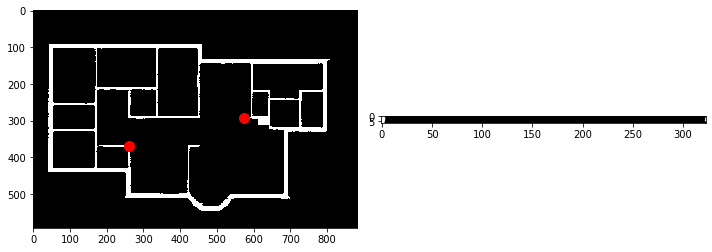

0.021671826625386997


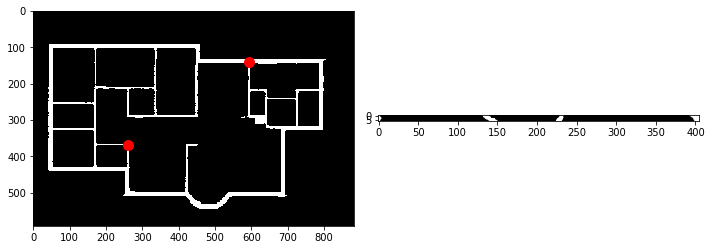

0.1259259259259259


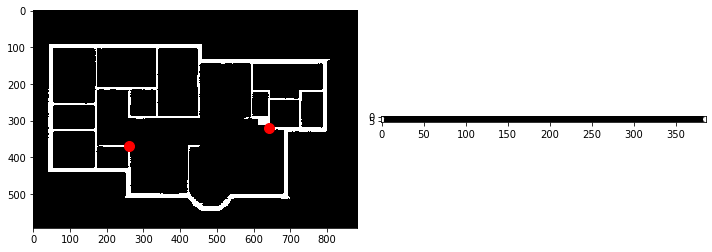

0.023316062176165803


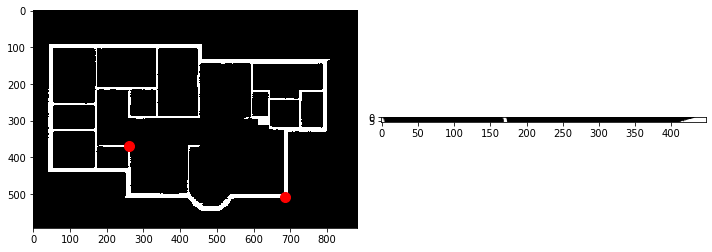

0.11607142857142858


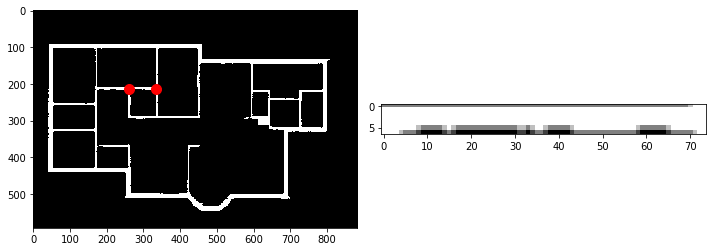

1.0


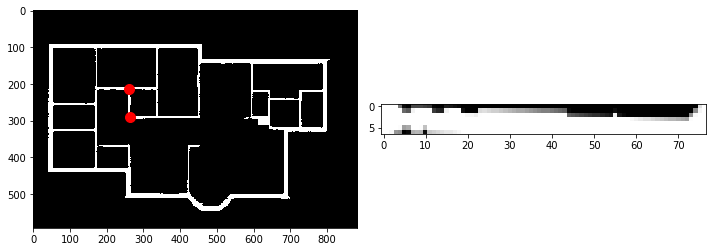

1.0


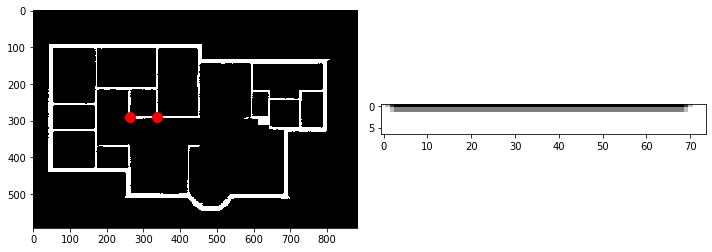

1.0


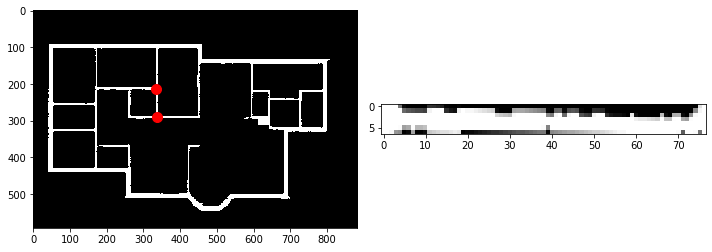

1.0


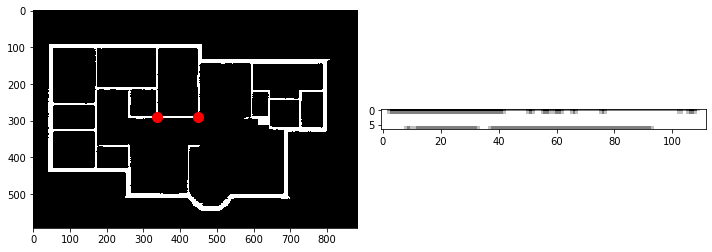

1.0


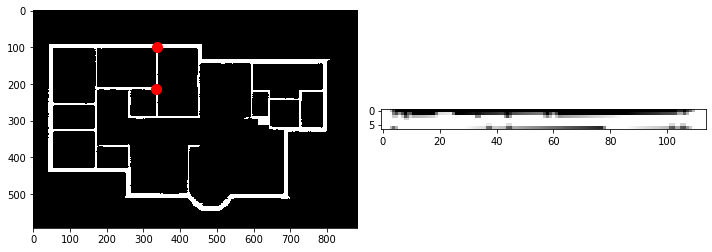

1.0


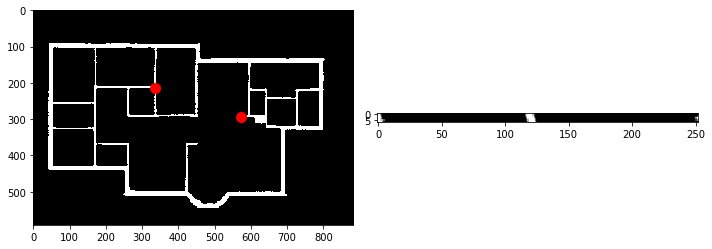

0.07936507936507936


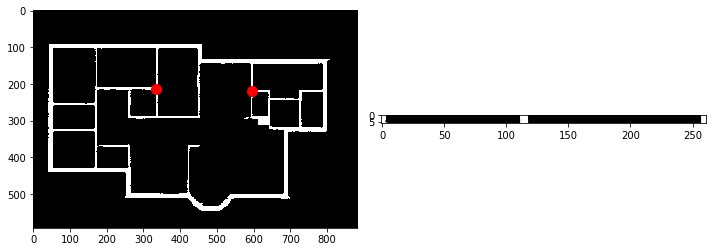

0.06896551724137931


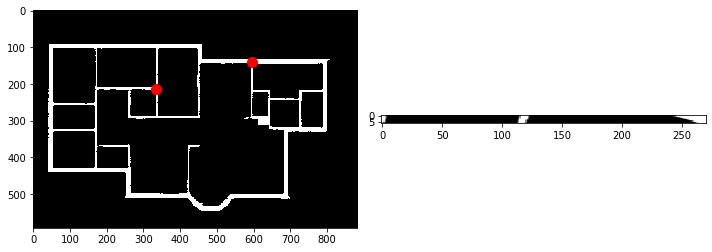

0.17407407407407408


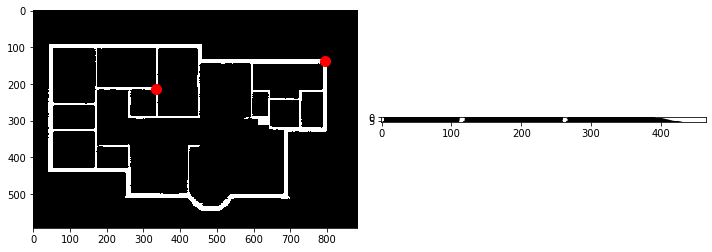

0.210752688172043


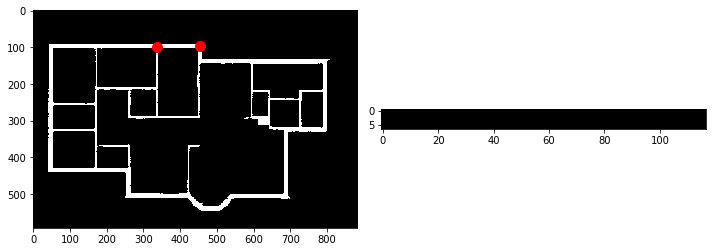

1.0


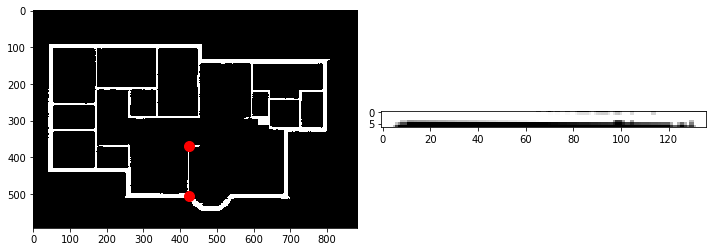

1.0


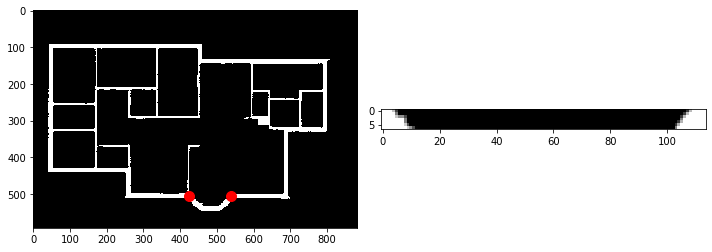

0.21052631578947367


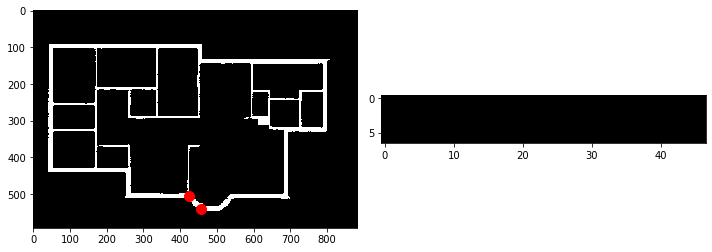

1.0


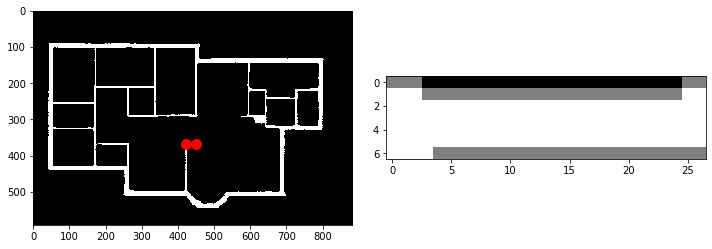

1.0


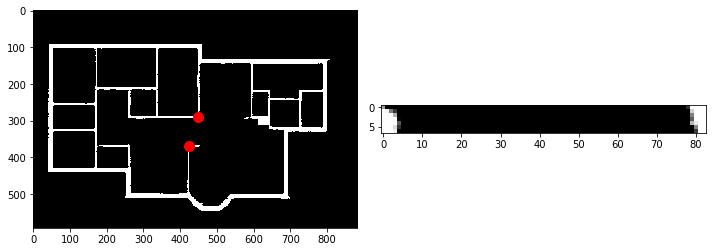

0.12048192771084337


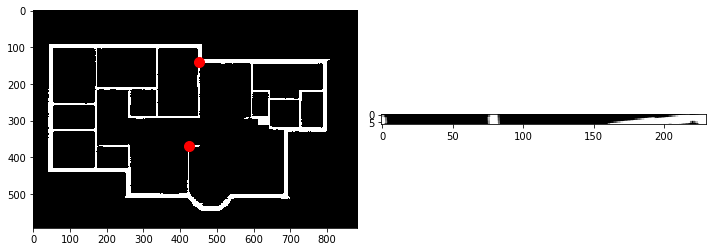

0.3652173913043478


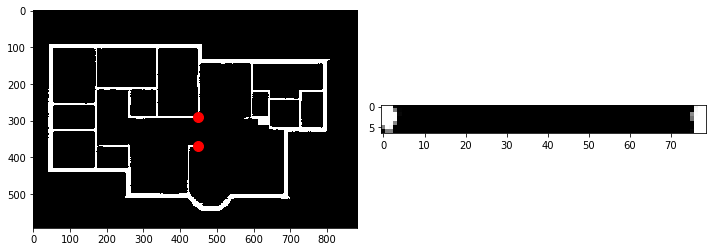

0.11392405063291139


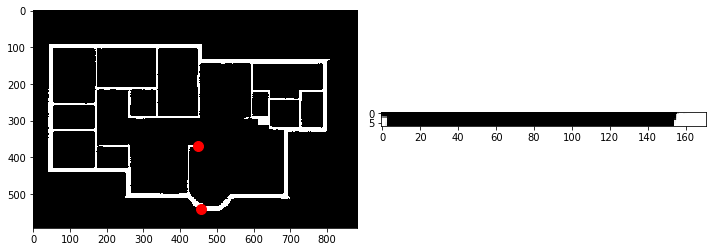

0.12280701754385964


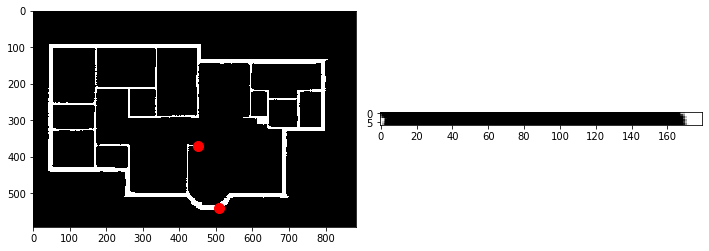

0.1


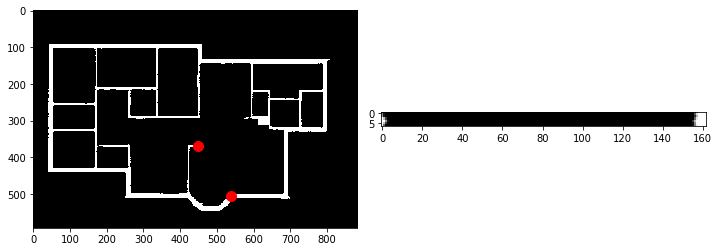

0.06790123456790123


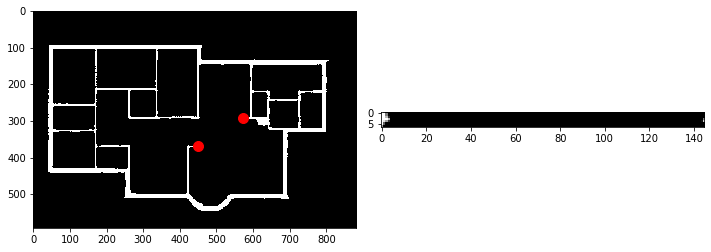

0.041379310344827586


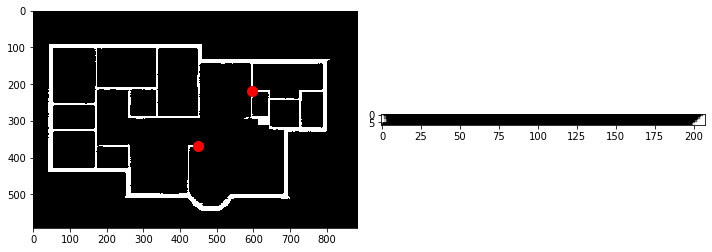

0.0673076923076923


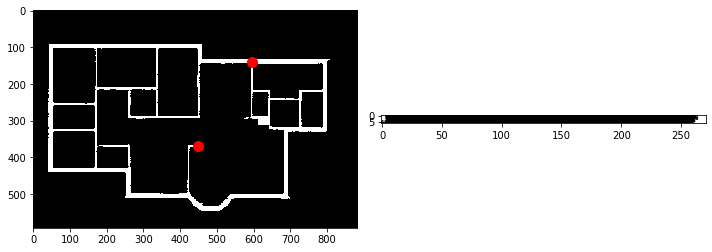

0.055350553505535055


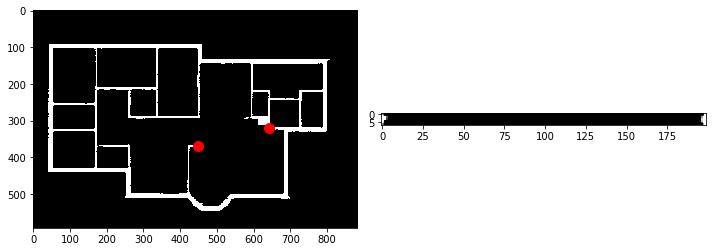

0.04020100502512563


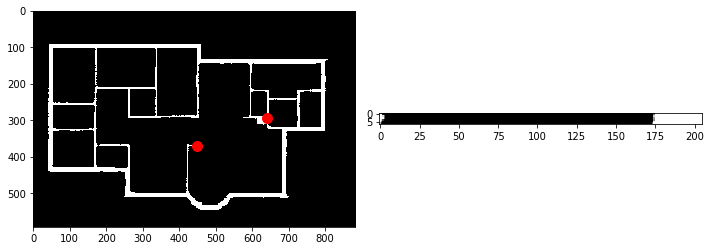

0.17560975609756097


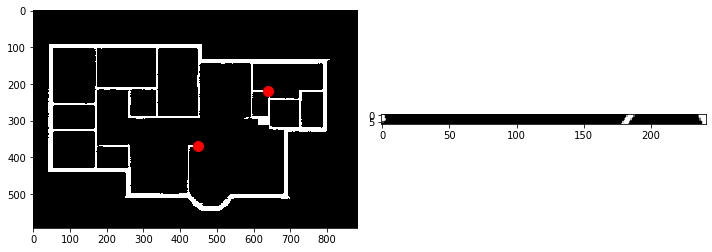

0.0954356846473029


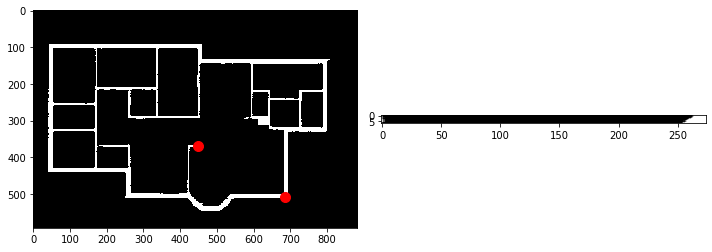

0.08759124087591241


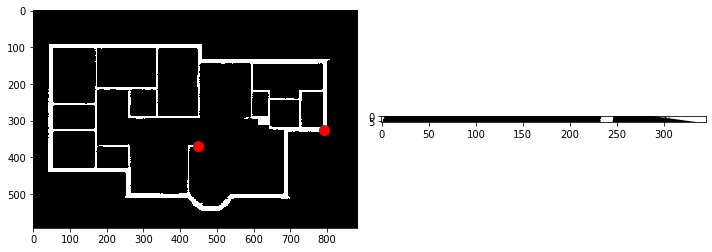

0.24347826086956523


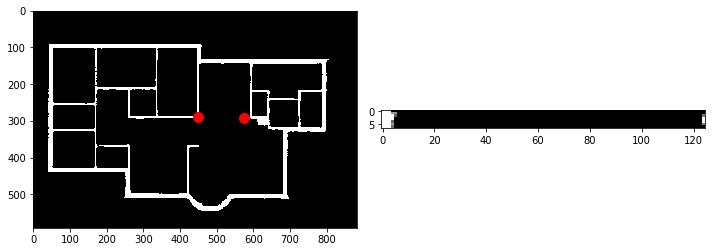

0.056


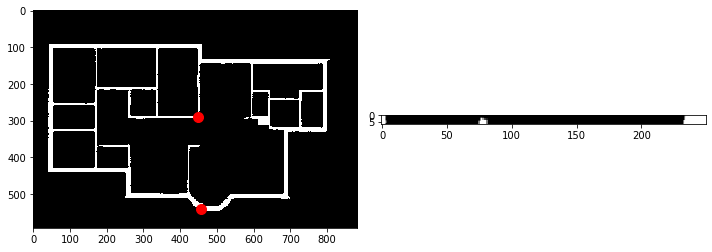

0.128


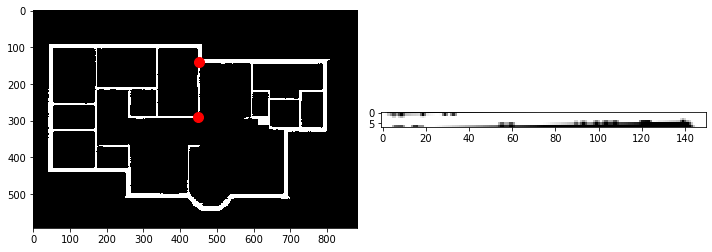

1.0


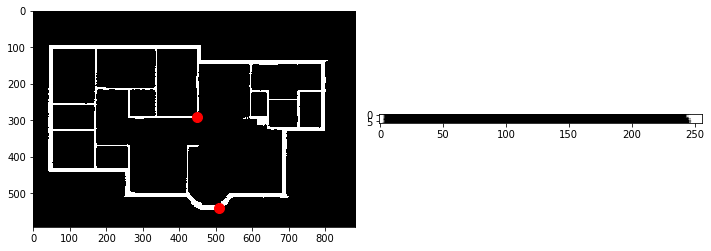

0.07421875


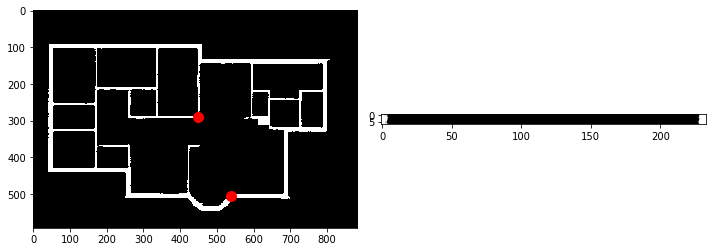

0.04721030042918455


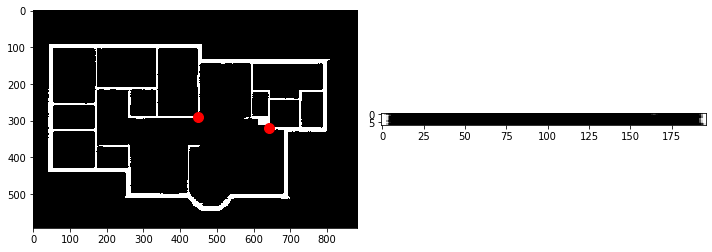

0.07142857142857142


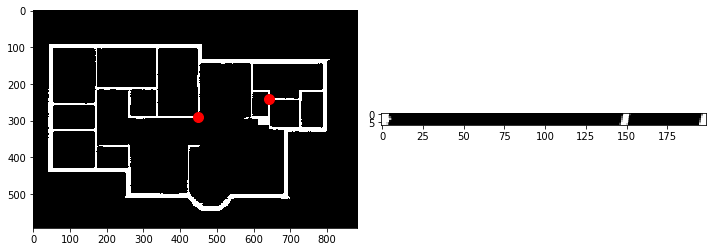

0.09045226130653267


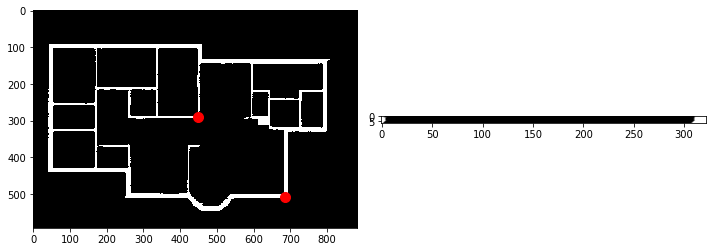

0.06521739130434782


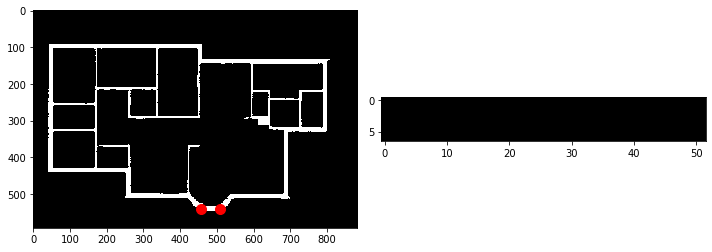

1.0


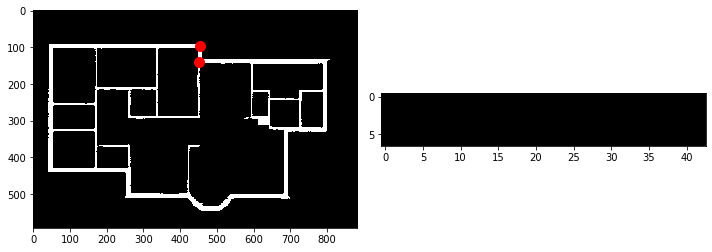

1.0


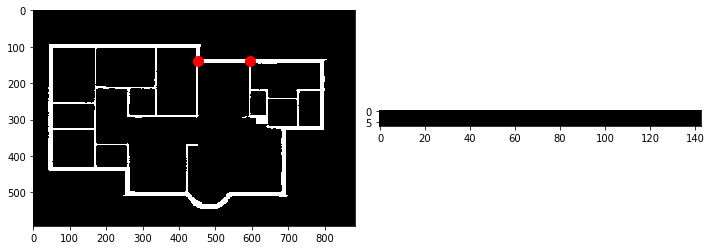

1.0


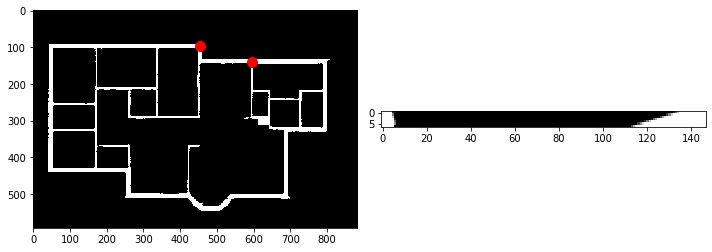

0.2857142857142857


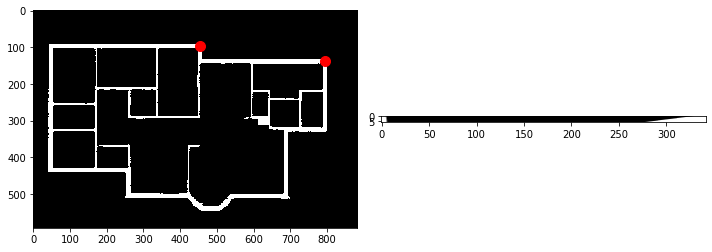

0.20760233918128654


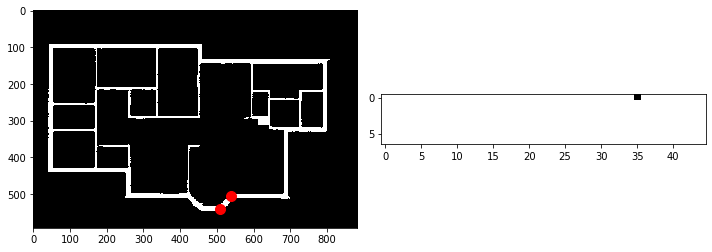

1.0


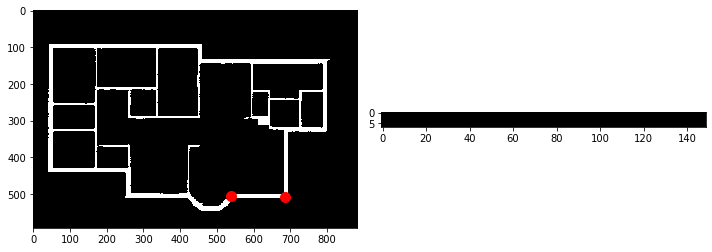

1.0


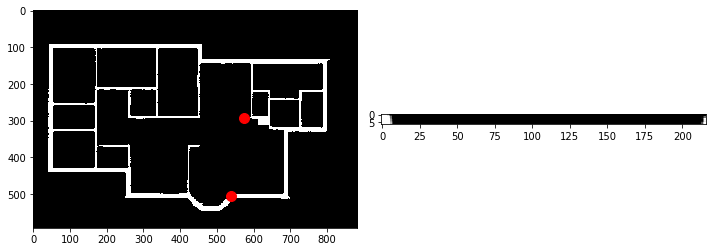

0.05092592592592592


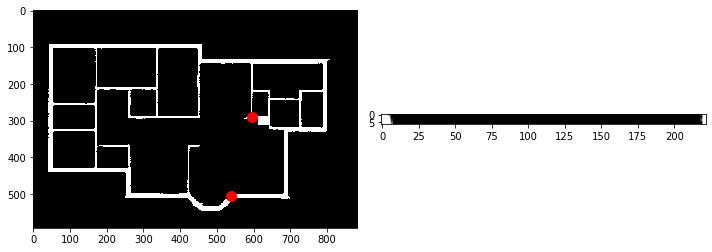

0.05405405405405406


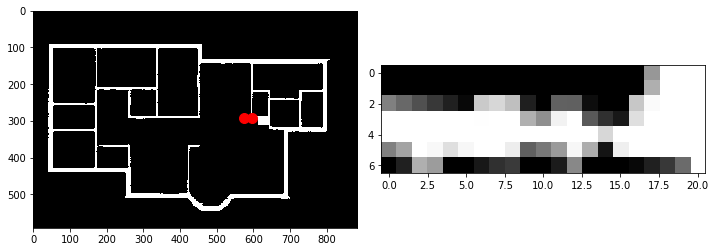

1.0


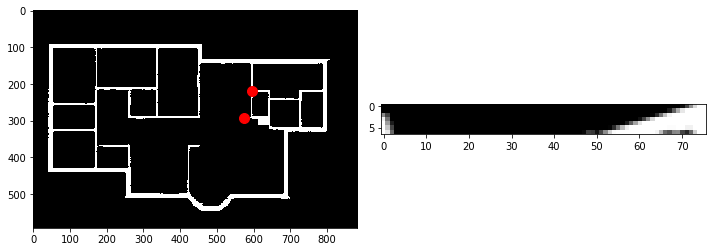

0.42105263157894735


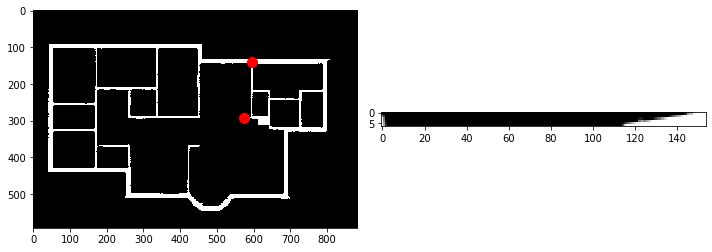

0.2792207792207792


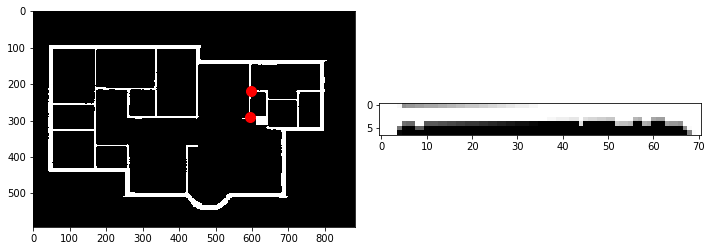

1.0


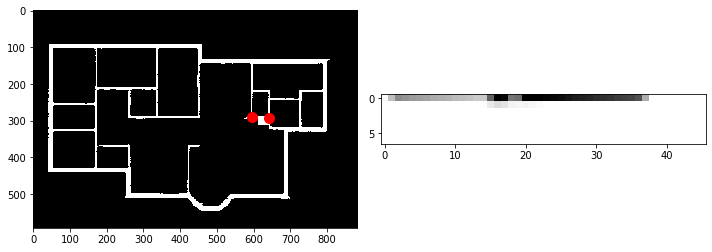

1.0


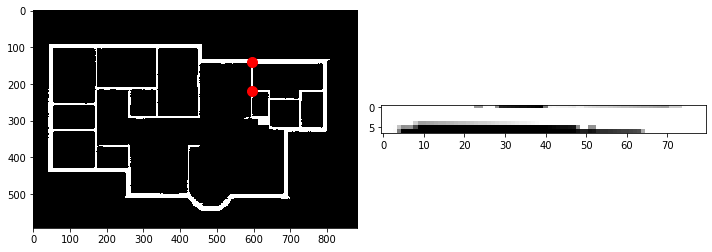

1.0


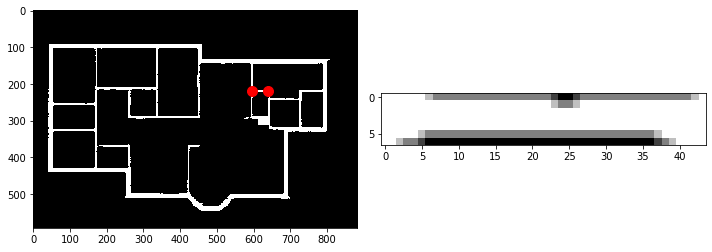

1.0


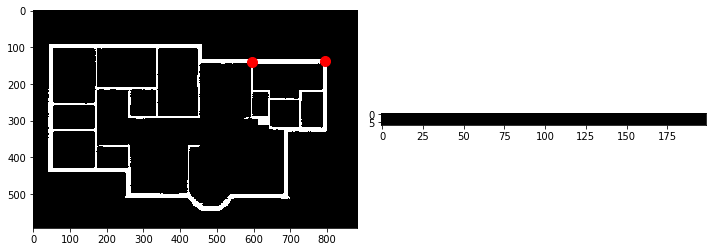

1.0


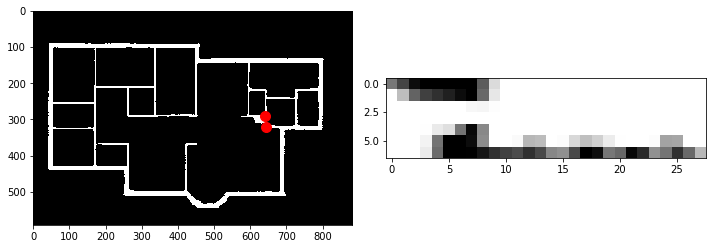

1.0


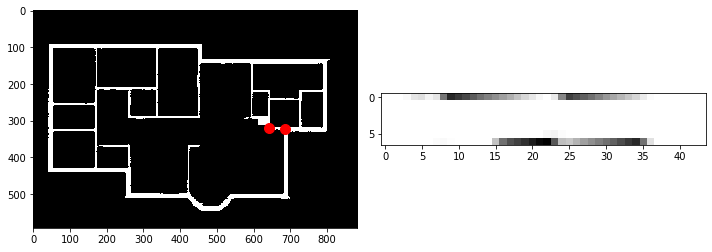

1.0


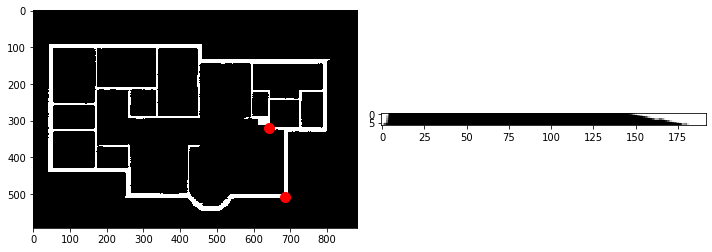

0.265625


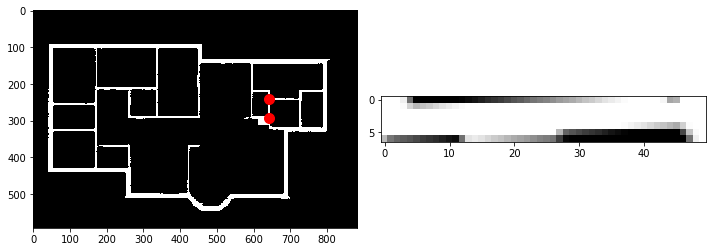

1.0


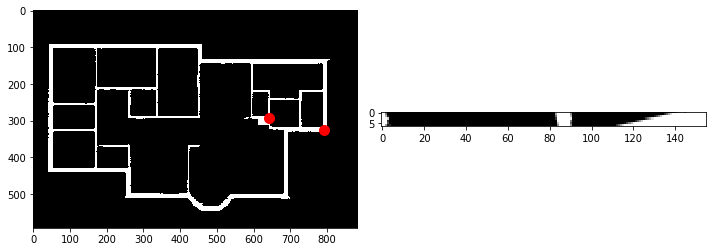

0.36774193548387096


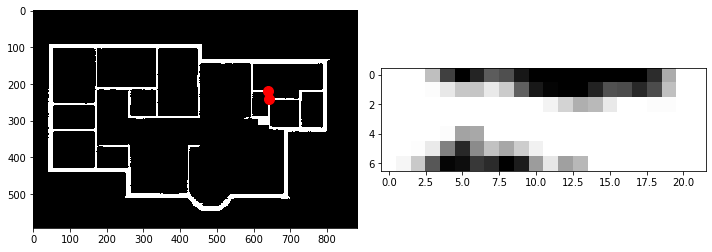

1.0


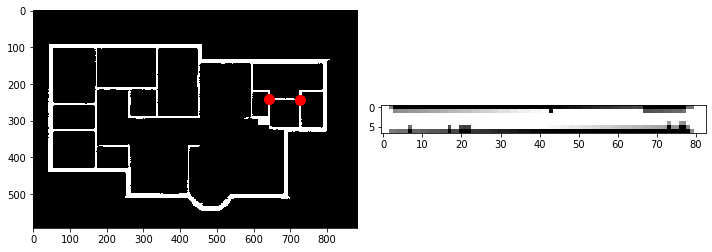

1.0


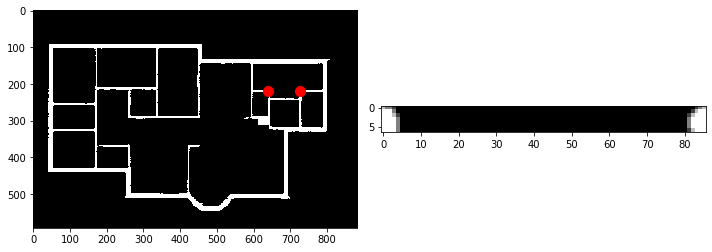

0.11627906976744186


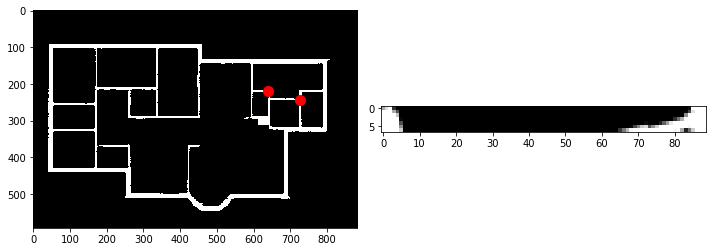

0.33707865168539325


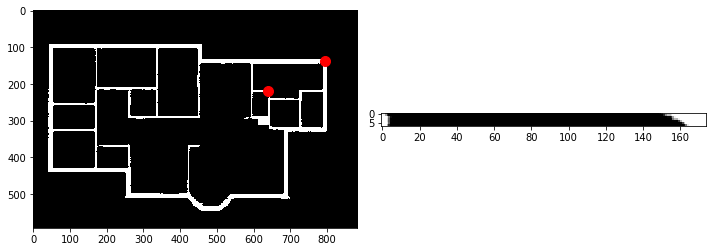

0.1781609195402299


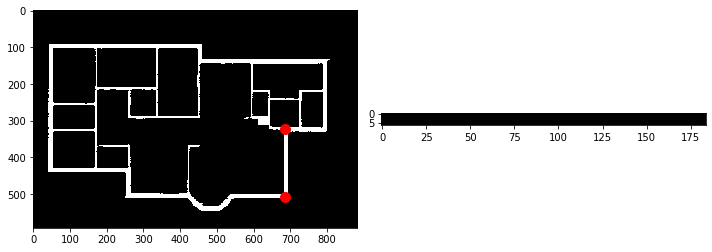

1.0


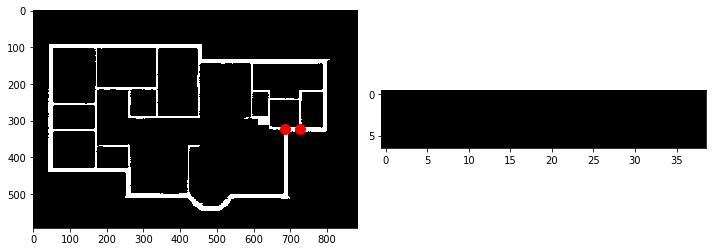

1.0


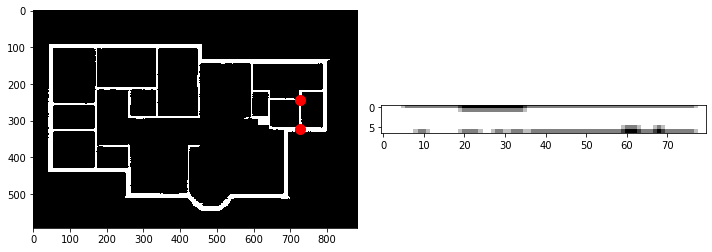

1.0


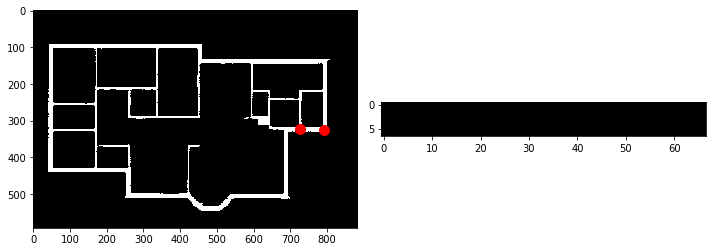

1.0


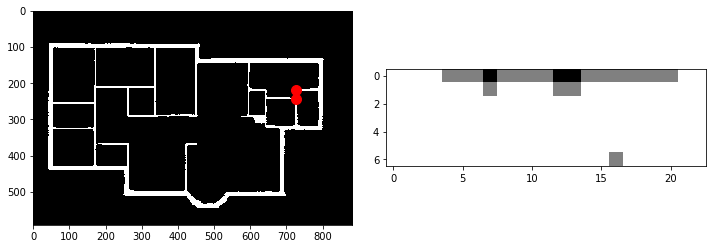

1.0


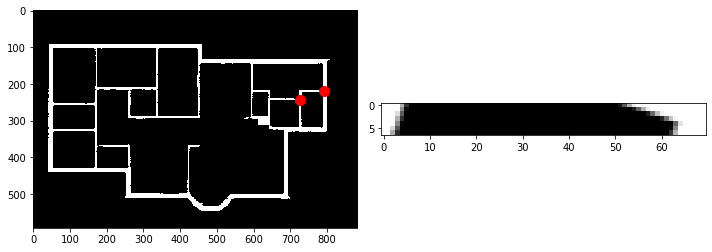

0.35714285714285715


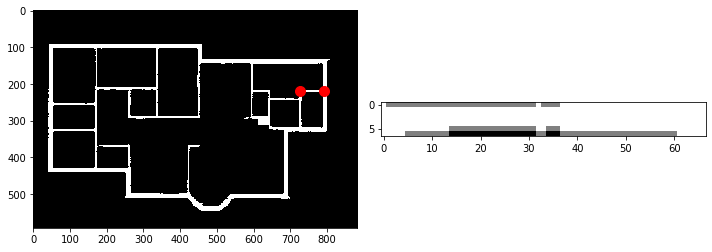

1.0


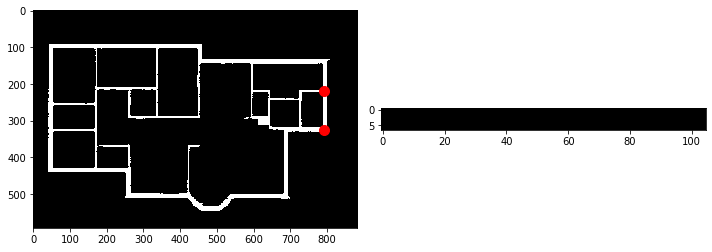

1.0


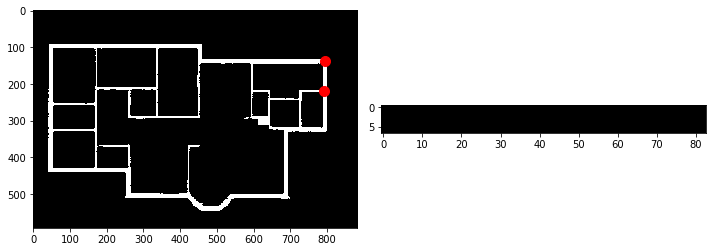

1.0


In [38]:
walls = get_walls(heatmaps, walls_closed)

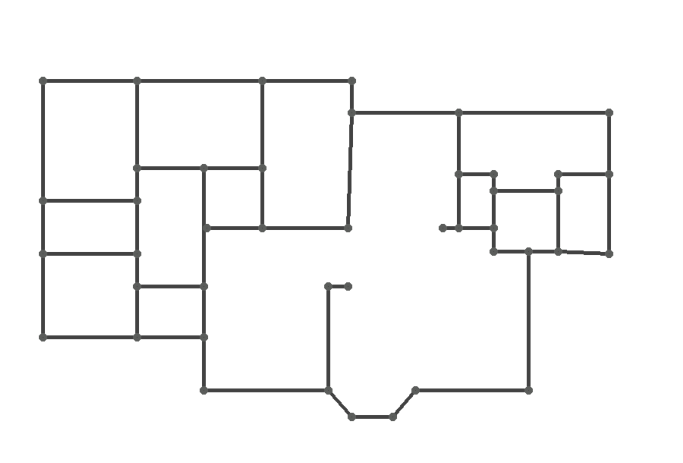

In [36]:
reconstr = np.copy(original)
reconstr = np.full(original.shape, 255).astype(np.uint8)
for wall in walls:
    s, e = wall
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

for wall in walls:
    s, e = wall
    reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
    reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)

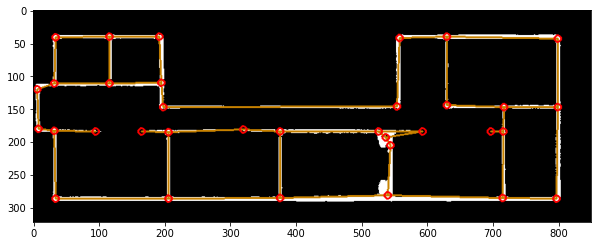

In [23]:
def show_img(im, walls=None, elements=None):
    im = np.expand_dims(im, axis=2).repeat(3, axis=2) 

    if walls:
        for w in walls:
            s, e = w['points'][0], w['points'][1]
            im = cv2.line(im, np.intp(s), np.intp(e), color=(200, 130, 0), thickness=2)
            im = cv2.circle(im, np.intp(s), color=(255, 0, 0), radius=5, thickness=2)
            im = cv2.circle(im, np.intp(e), color=(255, 0, 0), radius=5, thickness=2)

    if elements:
        for el in elements:
            s, e = el['points'][0], el['points'][1]
            ps, pe = el['perp'][0], el['perp'][1]

            color = (0, 255, 0) if el['type'] == 'window' else (0, 0, 255)
            pcolor = (50, 50, 210) if el['type'] == 'window' else (50, 210, 50) 
            im = cv2.line(im, np.intp(s), np.intp(e), color=color, thickness=2)
            im = cv2.line(im, np.intp(ps), np.intp(pe), color=pcolor, thickness=2)

    plt.figure(figsize=(10,10))
    plt.imshow(im)

show_img(walls_closed, walls)

In [24]:
doors = get_opening_lines(doors_pixels)
doors = tuple({'points': d, 'type': 'door'} for d in doors)
# FIXME: classify door as to be run after attaching to walls

windows = get_opening_lines(windows_pixels)
windows = tuple({'points': w, 'type': 'window'} for w in windows)


In [25]:
elements = tuple(el for el in doors + windows if np.linalg.norm(vector(el['points'])) > 10) 
print(len(elements))


12


{'points': array([[716.5, 168. ],
       [716.5, 155. ]], dtype=float32), 'type': 'door', 'perp': array([[711.5, 161.5],
       [721.5, 161.5]], dtype=float32)}


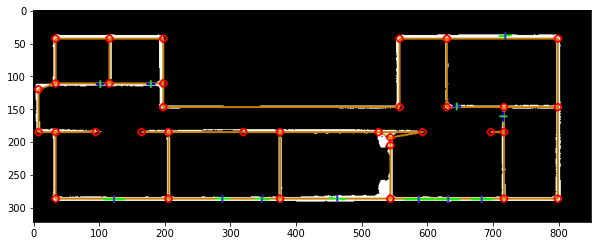

In [16]:
element_lines =  tuple({**e, 'perp': element_segment(e['points'])} for e in elements)
# element_lines =  tuple({**e, 'perp': e['points']} for e in doors + windows)
print(element_lines[0])
show_img(walls_closed, walls, element_lines)

In [26]:
walls = attach_openings(walls, elements, True)
walls

100%|██████████| 41/41 [00:00<00:00, 2255.80it/s]


({'points': array([[376., 184.],
         [526., 184.]], dtype=float32)},
 {'points': array([[376. , 184. ],
         [376.5, 285.5]], dtype=float32)},
 {'points': array([[376., 184.],
         [320., 181.]], dtype=float32)},
 {'points': array([[526., 184.],
         [537., 193.]], dtype=float32)},
 {'points': array([[526., 184.],
         [593., 184.]], dtype=float32)},
 {'points': array([[544. , 205. ],
         [540. , 281.5]], dtype=float32)},
 {'points': array([[544., 205.],
         [537., 193.]], dtype=float32)},
 {'points': array([[540. , 281.5],
         [376.5, 285.5]], dtype=float32),
  'elements': [{'points': array([[451.0045 , 285.93365],
           [475.96024, 287.59735]], dtype=float32),
    'type': 'window'}]},
 {'points': array([[540. , 281.5],
         [715.5, 285.5]], dtype=float32),
  'elements': [{'points': array([[667., 287.],
           [700., 287.]], dtype=float32),
    'type': 'window'},
   {'points': array([[614., 287.],
           [650., 287.]], dtype=float32

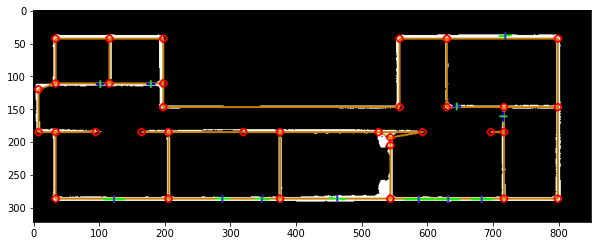

In [18]:
walls = normalize_wall_points(walls, 5)
show_img(walls_closed, walls, element_lines)

[{'points': array([[451.0045 , 285.93365],
       [475.96024, 287.59735]], dtype=float32), 'type': 'window'}]
[{'points': array([[667., 287.],
       [700., 287.]], dtype=float32), 'type': 'window'}, {'points': array([[614., 287.],
       [650., 287.]], dtype=float32), 'type': 'window'}, {'points': array([[565., 287.],
       [610., 287.]], dtype=float32), 'type': 'window'}]
[{'points': array([[338.06226, 286.00394],
       [359.97662, 287.37357]], dtype=float32), 'type': 'window'}, {'points': array([[278. , 286.5],
       [299. , 286.5]], dtype=float32), 'type': 'window'}]
[{'points': array([[107., 287.],
       [139., 287.]], dtype=float32), 'type': 'window'}]
[{'points': array([[716.5, 168. ],
       [716.5, 155. ]], dtype=float32), 'type': 'door'}]


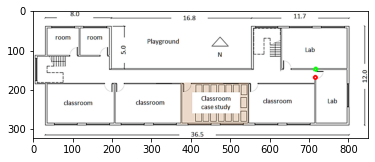

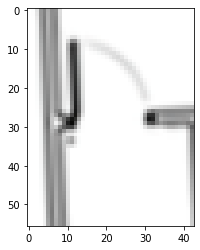

single_ul
[{'points': array([[639. , 146.5],
       [651. , 146.5]], dtype=float32), 'type': 'door'}]


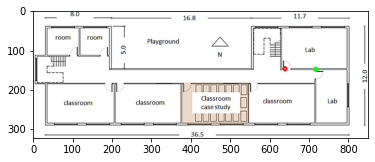

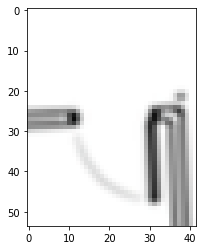

single_dr
[{'points': array([[ 96. , 112.5],
       [108. , 112.5]], dtype=float32), 'type': 'door'}]


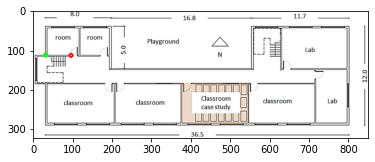

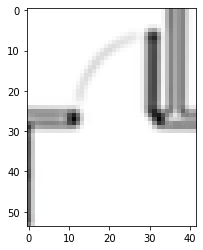

single_ur
[{'points': array([[173. , 112.5],
       [185. , 112.5]], dtype=float32), 'type': 'door'}]


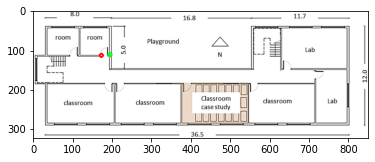

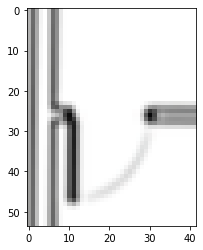

single_dl
[{'points': array([[710.05865,  39.99655],
       [728.9931 ,  38.88276]], dtype=float32), 'type': 'window'}]


In [27]:
from door_classification import crop_door

for wall in walls:
    if 'elements' in wall:
        print(wall['elements'])
        for element in wall['elements']:
            if element['type'] != 'window':
                print('='*50)

                orig_img = original.copy()
                orig_img = cv2.circle(orig_img, np.intp(element['points'][0]), 4, (255, 0, 0,), 4)
                orig_img = cv2.circle(orig_img, np.intp(wall['points'][0]), 4, (0, 255, 0,), 4)
                plt.imshow(orig_img)
                plt.show()

                cropped_door = crop_door(element, wall, original)
                plt.imshow(cropped_door)
                plt.show()

                element['type'] = classify_door(element, wall, original)
                print(element['type'])

# Just call main

In [1]:
from recognition import *
import matplotlib.pyplot as plt

/mnt/c/Users/joaodavid/Desktop/practical/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = main('01_Ground_floor_plan.png')
results

2022-05-04 15:41:31,286 INFO - Performing segmentation
2022-05-04 15:42:15,342 INFO - Simplifying contours
2022-05-04 15:42:16,344 INFO - Converting polygons to walls
2022-05-04 15:43:29,833 INFO - Calculating wall width
100%|██████████| 290/290 [00:00<00:00, 1715582.74it/s]
2022-05-04 15:43:29,852 INFO - Identifying wall openings and associating them with their respective walls
100%|██████████| 290/290 [00:01<00:00, 176.83it/s]
2022-05-04 15:43:31,657 INFO - Classifying doors individually
100%|██████████| 290/290 [00:04<00:00, 64.86it/s] 
2022-05-04 15:43:36,132 INFO - Retrieving icons
2022-05-04 15:43:36,139 INFO - Finished


{'walls': [{'points': array([[  68. , 1391.5],
          [ 168. , 1381.5]], dtype=float32)},
  {'points': array([[  68. , 1391.5],
          [ 168. , 1391.5]], dtype=float32)},
  {'points': array([[  55.75, 1391.5 ],
          [  68.  , 1391.5 ]], dtype=float32)},
  {'points': array([[ 168. , 1391.5],
          [ 168. , 1381.5]], dtype=float32)},
  {'points': array([[ 168. , 1381.5],
          [ 168. , 1310. ]], dtype=float32)},
  {'points': array([[ 168. , 1391.5],
          [ 234. , 1393. ]], dtype=float32),
   'elements': [{'points': array([[ 181. , 1392.5],
            [ 218. , 1392.5]], dtype=float32),
     'type': 'window'}]},
  {'points': array([[1278.5, 1393. ],
          [1279. , 1276.5]], dtype=float32)},
  {'points': array([[1278.5  , 1165.375],
          [1279.   , 1276.5  ]], dtype=float32)},
  {'points': array([[1217.5, 1276.5],
          [1279. , 1276.5]], dtype=float32),
   'elements': [{'points': array([[1237., 1276.],
            [1267., 1276.]], dtype=float32),
     

In [4]:
original = cv2.imread('01_Ground_floor_plan.png')
im = np.full(original.shape, 255).astype(np.uint8)

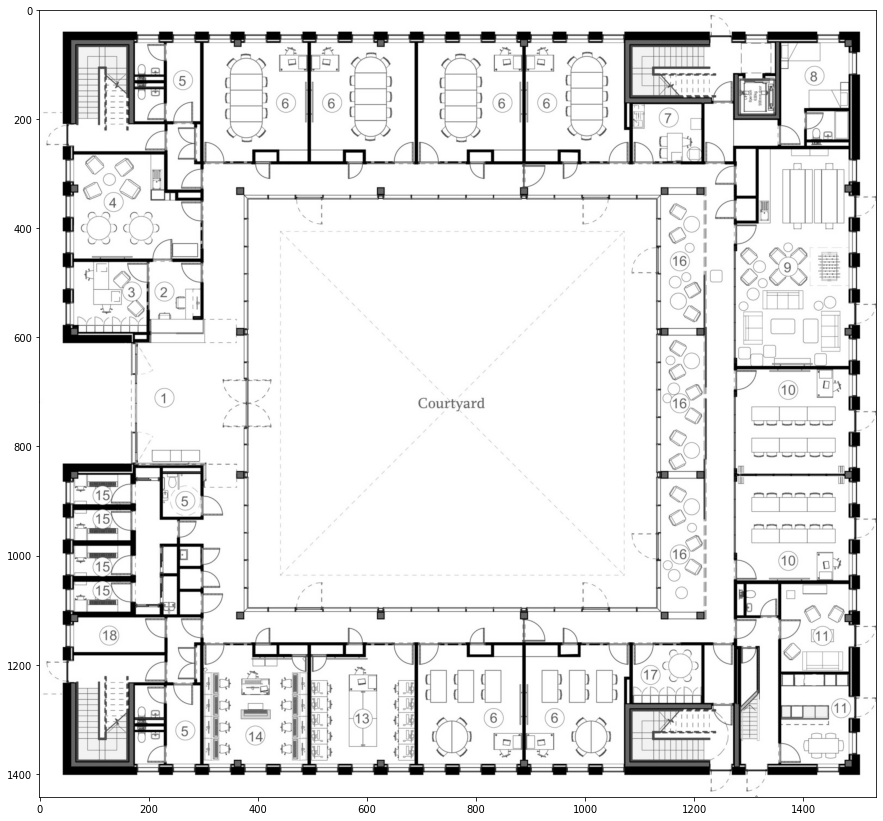

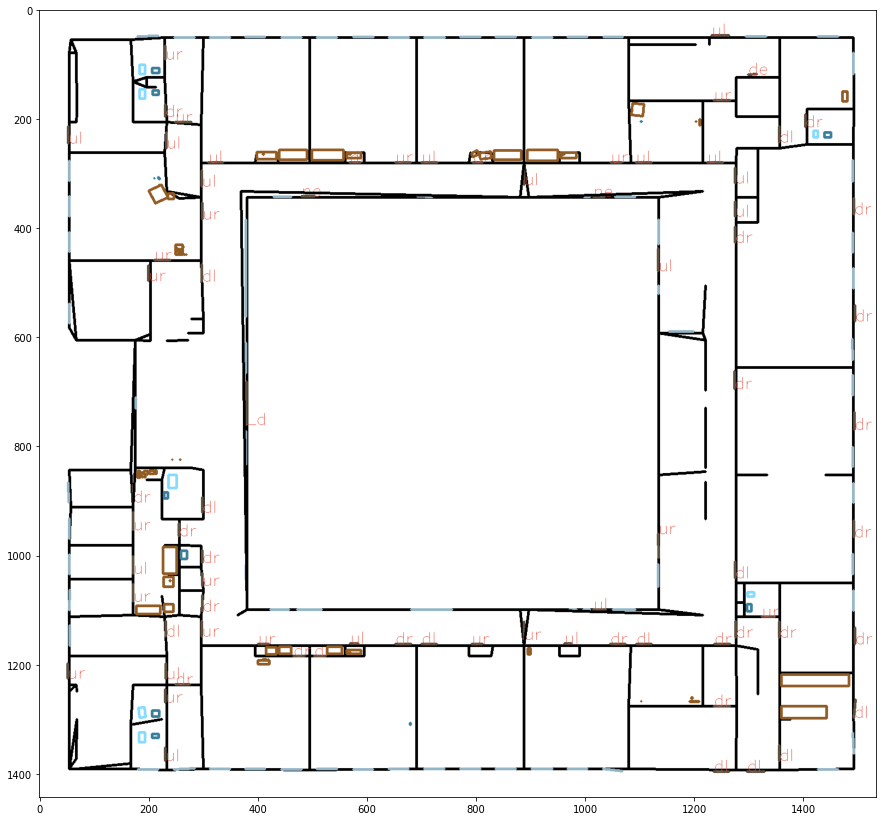

In [5]:
reconstr = im.copy()
for wall in results['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (0, 0, 0), 3)

    if 'elements'  in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (147, 181, 198), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (94, 80, 63), 3)
                reconstr = cv2.putText(
                    reconstr, el['type'][-2:],
                    np.intp(s),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (230, 80, 63), 1, 2
                )

icons = ('closet', 'toilet', 'sink', 'bathtub')
colors = ((145, 91, 36), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
for icon in results['icons']:
    # pts = np.intp(icon['points'])
    # print(pts, pts.shape, pts.reshape((-1, 1, 2)))
    reconstr = cv2.drawContours(reconstr, [np.intp(icon['points'])], 0, colors[icons.index(icon['type'])], 3)

plt.figure(figsize=(15, 15))
plt.imshow(original)

plt.figure(figsize=(15, 15))
plt.imshow(reconstr)
plt.show()